<a href="https://www.kaggle.com/code/annkuruvilla/movie-reviews-nb-cnn-bilstm-pytorch?scriptVersionId=130502556" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [77]:
import numpy as np 
import pandas as pd 

In [78]:
!ls /kaggle/usr/lib/

model_utilities


In [79]:
import model_utilities as util

This notebook helps in familiarising with the usage of some NLP models that could be used for text classification.  
Mainly Three Models are used here:  

**Gaussian Naive Bayes Model  
One dimesional convolutional Model  
Bi LSTM Model**

My understanding of these models are also described below. Currently only accuracy is used for any kind of evaluation here.

In [86]:
train_data_path='../input/movie-review-data-set-from-rotten-tomatoes/train.csv'
test_data_path='../input/movie-review-data-set-from-rotten-tomatoes/test.csv'
validation_data_path='../input/movie-review-data-set-from-rotten-tomatoes/validation.csv'

In [87]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)
val_data=pd.read_csv(validation_data_path)

In [88]:
train_data.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


<AxesSubplot:>

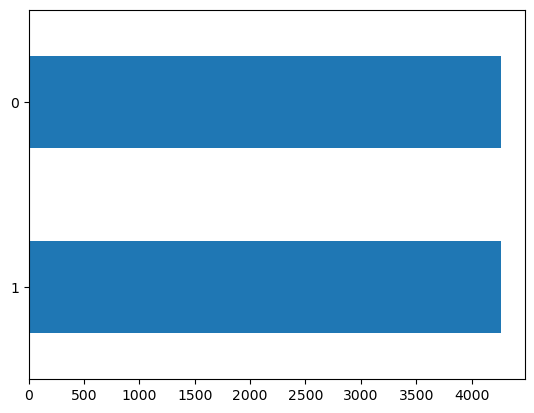

In [89]:
train_data.label.value_counts().plot.barh()

*The data seems to be pre-processed already with  no class-imbalance. So minimal preprocessing is done later with more focus on the models.*

In [91]:
%%capture
#Installations
!pip install contractions

In [93]:
import string
import contractions
import spacy
import matplotlib.pyplot as plt

In [94]:
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words
punct_string=string.punctuation.replace('\'','')

In [95]:
punct_dict={}
for punct in punct_string:
    punct_dict[ord(punct[0])]=' ' 

def remove_punct(punct_dict,text):
    return text.translate(punct_dict)  
    
    
def preprocess(text,punct_dict=punct_dict):
    text=" ".join([contractions.fix(token.strip()) for token in text.split()])
    text=remove_punct(punct_dict,text).replace("  "," ")   
    text=" ".join([token for token in text.split() if (token not in stopwords)])
    return text.strip() 

In [96]:
train_data["text"]=train_data["text"].apply(preprocess)
test_data["text"]=test_data["text"].apply(preprocess)
val_data["text"]=val_data["text"].apply(preprocess)

In [97]:
get_len={lambda x: len(x.split())}
len_frame=pd.DataFrame()
len_frame['len']=train_data['text'].apply(get_len)

In [98]:
len_frame['len'].quantile(q=[0.1,0.9])

0.1     4.0
0.9    16.0
Name: len, dtype: float64

In [99]:
train_data=train_data[len_frame['len']>0]

## WordCloud

In [100]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [101]:
#Positive and negative review
stopwords=list(STOPWORDS)+["movie","film","make","one","makes","story","time","character"]

pos_index=train_data[train_data['label']==1]
neg_index=train_data[train_data['label']==0]

pos_reviews=list(pos_index['text'])
neg_reviews=list(neg_index['text'])

pos_wordcloud = WordCloud(width=800, height=500,stopwords=stopwords, background_color="white").generate(str(pos_reviews))
neg_wordcloud=WordCloud(width=800, height=500,stopwords=stopwords, background_color="black").generate(str(neg_reviews))

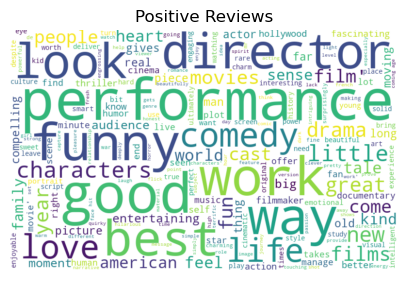

In [102]:
plt.figure(figsize=[5,5])
plt.title("Positive Reviews")
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

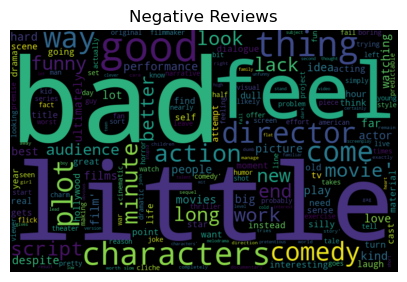

In [103]:
plt.figure(figsize=[5,5])
plt.title("Negative Reviews")
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vocabulary,DataSet,DataLoader

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [105]:
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [106]:
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
    
print(device)

cuda


In [107]:
train_text_list=list(train_data['text'])
vocab_obj=util.Vocabulary(train_text_list)
vocab_obj.make_token_dicts()

# **Models**

# Gaussian Naive Bayes Model

The variant of Naive Bayes classifier where, the features of the data in each class , is assumed to have come from their respective gaussian distributions. So the likelihood factor for computing the final conditional probabilities is  calculated from these previously mentioned distributions. The tfidf vectoriser helps in converting the text numerical feature values before using the Gaussian Naive Bayes Classifier.

In [108]:
train_data.head()

,text,label
0,rock destined 21st century's new conan going s...,1
1,gorgeously elaborate continuation lord rings t...,1
2,effective tepid biopic,1
3,like movies fun wasabi good place start,1
4,emerges rare issue movie honest keenly observe...,1


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

In [110]:
train_x=list(train_data['text'])
train_y=list(train_data['label'])

val_x=list(val_data['text'])
val_y=list(val_data['label'])

test_x=list(test_data['text'])
test_y=list(test_data['label'])

In [111]:
tfidf_vectoriser = TfidfVectorizer(max_features = len(vocab_obj)) 

train_vectors = tfidf_vectoriser.fit_transform(train_x).toarray()
train_y=np.array(train_y)

val_vectors = tfidf_vectoriser.transform(val_x).toarray()
val_y=np.array(val_y)

test_vectors = tfidf_vectoriser.transform(test_x).toarray()
test_y=np.array(test_y)

In [112]:
nb_model=GaussianNB()
nb_model.fit(train_vectors,train_y)

GaussianNB()

In [113]:
train_score=nb_model.score(train_vectors,train_y)
validation_score=nb_model.score(val_vectors,val_y)
test_score=nb_model.score(test_vectors,test_y)

In [114]:
print(f" Train Score: {train_score*100.0} , Validation Score : {validation_score*100.0} , Test Score: {test_score*100.0} ,  ")

 Train Score: 94.52263664086324 , Validation Score : 63.977485928705434 , Test Score: 67.7298311444653 ,  


# 1D Convolution Network

 Here "output_size" number of filters,  of the form (feature_size,kernel_size) is created for each layer of convolution. The convolutions majory happen in one direction ( ie.. sequence length) instead of the most common 2-D way. An filter's tensor shapes are shown below

In [115]:
#Sample
input_feature_size=128
output_size=32
kernel_size=7

conv_filter = nn.Conv1d(input_feature_size, output_size, kernel_size=kernel_size, padding="same")

for param in conv_filter.parameters():
    print(param.shape)  


torch.Size([32, 128, 7])
torch.Size([32])


In [116]:
class ConvolutionModel(nn.Module):
    def __init__(self,vocab_obj,embed_dim):
        super(ConvolutionModel,self).__init__()
        self.token_count=len(vocab_obj)
        self.embed_dim=embed_dim       
        self.embedding=nn.Embedding(len(vocab_obj),embed_dim)
        self.conv1=nn.Sequential(nn.Conv1d(embed_dim,512,kernel_size=4,padding='same'),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout1d(0.5))
        self.conv2=nn.Sequential(nn.Conv1d(512,256,kernel_size=8,padding='same'),nn.BatchNorm1d(256),nn.ReLU(),nn.Dropout1d(0.3))
        self.conv3=nn.Sequential(nn.Conv1d(256,64,kernel_size=8,padding='same'),nn.BatchNorm1d(64),nn.ReLU(),nn.Dropout1d(0.1))
        self.linear=nn.Sequential(nn.Linear(64,16),nn.ReLU(),nn.Linear(16,2))
        
        
    def forward(self,input):  #input shape: [batch_size,token_length]
        x=self.embedding(input)    #shape: [batch_size,token_length,embedding length]
        bs,tl,es=x.shape
        x=x.reshape(bs,es,tl)  #shape[batch_size, feature_length, token length]
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x,max_indices=x.max(dim=-1)
        x=self.linear(x)
        return x


In [117]:
def InitialliseModel(vocab_obj,embed_dim,device,init_func="xavier"):
    model=ConvolutionModel(vocab_obj,embed_dim).to(device)
    if init_func=="xavier":
        for param in model.parameters():
            if(len(param.shape)>=2):
                nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu'))                
    elif init_func=="kaiming":
        for param in model.parameters():
            if(len(param.shape)>=2):
                nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')         
    return model

In [118]:
def print_model(model):
    for child in model.children():
        print(f"Module Name: {child}")
    return   

In [119]:
embed_dim=512  #300
init_func="kaiming"
model=InitialliseModel(vocab_obj,embed_dim,device,init_func)
print_model(model)

Module Name: Embedding(17078, 512)
Module Name: Sequential(
  (0): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=same)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout1d(p=0.5, inplace=False)
)
Module Name: Sequential(
  (0): Conv1d(512, 256, kernel_size=(8,), stride=(1,), padding=same)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout1d(p=0.3, inplace=False)
)
Module Name: Sequential(
  (0): Conv1d(256, 64, kernel_size=(8,), stride=(1,), padding=same)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout1d(p=0.1, inplace=False)
)
Module Name: Sequential(
  (0): Linear(in_features=64, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
)


In [120]:
batch_size=32
epochs=10

cnn_train_dataset,cnn_train_loader=util.get_loader(train_data,vocab_obj,batch_size,max_len=100)
cnn_val_dataset,cnn_val_loader=util.get_loader(val_data,vocab_obj,batch_size,max_len=100)
cnn_test_dataset,cnn_test_loader=util.get_loader(test_data,vocab_obj,batch_size,max_len=100)

loss_function=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(model.parameters())

train_batches=len(cnn_train_dataset)//batch_size 
val_batches=len(cnn_val_dataset)//batch_size
test_batches=len(cnn_test_dataset)//batch_size

print(f"Train Batchcount: {train_batches} ,Test Batchcount: {test_batches} , Validation Batchcount: {val_batches} ")

Train Batchcount: 266 ,Test Batchcount: 33 , Validation Batchcount: 33 


In [121]:
util.training(model,cnn_train_loader,train_batches,cnn_val_loader,val_batches,loss_function,optimiser,epochs,device,if_clip=True)

Train Loss: 3.3457199406803104 	 Accuracy 50.01172882946282
Val Loss: 2.3908766056552078 	 Accuracy 49.15572232645403
*-----------------------------------------------------*

Train Loss: 1.475540620491917 	 Accuracy 51.14942528735632
Val Loss: 0.7693955898284912 	 Accuracy 51.313320825515945
*-----------------------------------------------------*

Train Loss: 0.665959391714935 	 Accuracy 65.08327468918601
Val Loss: 0.5985420951337526 	 Accuracy 69.8874296435272
*-----------------------------------------------------*

Train Loss: 0.3532004933104031 	 Accuracy 85.5852685901947
Val Loss: 0.633560398311326 	 Accuracy 72.42026266416511
*-----------------------------------------------------*

Train Loss: 0.19594479866213815 	 Accuracy 92.92751583391977
Val Loss: 0.8024343098654891 	 Accuracy 70.82551594746717
*-----------------------------------------------------*

Train Loss: 0.12464109497298871 	 Accuracy 95.3319258737978
Val Loss: 1.0151813237956075 	 Accuracy 69.69981238273921
*---------

In [122]:
util.testing(model,cnn_test_loader,test_batches,loss_function,device)

test Loss: 1.2967615380431667 	 Accuracy 72.13883677298311


# Bi LSTM

The multilayer-lstm's outputs from both directions, forward and backward are used here (since we have a complete sentence)  and the only output at the  last word is used here for final result.

In [124]:
class BiLSTMModel(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,batch_first,dropout,bi_directional,proj_size,n_classes,vocab_obj,device):
        super(BiLSTMModel,self).__init__()
        
        self.num_layers=num_layers
        self.proj_size=proj_size
        self.hidden_size=hidden_size 
        self.device=device
        self.d=2 if bi_directional else 1        
        self.embedding=nn.Embedding(len(vocab_obj),input_size)
        self.bi_lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=batch_first,bidirectional=bi_directional,proj_size=proj_size,dropout=dropout)
        self.linear=nn.Linear(self.d*proj_size,n_classes)
        
        
    def forward(self,input):        
        batch_size,seq_length=input.shape
        x=self.embedding(input)        
        hidden_init = torch.zeros(self.d*self.num_layers,batch_size,self.proj_size).to(device)
        cell_init = torch.zeros(self.d*self.num_layers,batch_size,self.hidden_size).to(device)
        x, (hidden_final, cell_final) = self.bi_lstm(x, (hidden_init, cell_init))
        x=x[:,-1,:]
        output=self.linear(x)
        return output

In [125]:
rnn_params={
    "input_size":128,
    "hidden_size":256,
    "num_layers":2,    
    "batch_first":True,
    "dropout":0.1,
    "bi_directional":True,
    "proj_size":2,
    "n_classes":2,
    "vocab_obj":vocab_obj,
    "device":device
            }

In [126]:
model=BiLSTMModel(**rnn_params).to(device)
print_model(model)

Module Name: Embedding(17078, 128)
Module Name: LSTM(128, 256, proj_size=2, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
Module Name: Linear(in_features=4, out_features=2, bias=True)


In [127]:
batch_size=32
epochs=6

rnn_train_dataset,rnn_train_loader=util.get_loader(train_data,vocab_obj,batch_size,max_len=100)
rnn_val_dataset,rnn_val_loader=util.get_loader(val_data,vocab_obj,batch_size,max_len=100)
rnn_test_dataset,rnn_test_loader=util.get_loader(test_data,vocab_obj,batch_size,max_len=100)

loss_function=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(model.parameters())

train_batches=len(rnn_train_dataset)//batch_size 
val_batches=len(rnn_val_dataset)//batch_size
test_batches=len(rnn_test_dataset)//batch_size

print(f"Train Batchcount: {train_batches} ,Test Batchcount: {test_batches} , Validation Batchcount: {val_batches} ")

Train Batchcount: 266 ,Test Batchcount: 33 , Validation Batchcount: 33 


In [128]:
util.training(model,rnn_train_loader,train_batches,rnn_val_loader,val_batches,loss_function,optimiser,epochs,device,if_clip=True)

Train Loss: 0.696755747373839 	 Accuracy 50.175932441942294
Val Loss: 0.714318750482617 	 Accuracy 50.0
*-----------------------------------------------------*

Train Loss: 0.693941690195772 	 Accuracy 51.677222613183204
Val Loss: 0.6833088994026184 	 Accuracy 61.72607879924953
*-----------------------------------------------------*

Train Loss: 0.5976583744798388 	 Accuracy 68.95378841191649
Val Loss: 0.6460987970684514 	 Accuracy 67.07317073170732
*-----------------------------------------------------*

Train Loss: 0.41587178498730626 	 Accuracy 82.3598404879193
Val Loss: 0.604622738830971 	 Accuracy 70.54409005628519
*-----------------------------------------------------*

Train Loss: 0.27257005377371507 	 Accuracy 89.7724607084213
Val Loss: 0.6841271438381888 	 Accuracy 71.95121951219512
*-----------------------------------------------------*

Train Loss: 0.16937576841450946 	 Accuracy 94.25287356321839
Val Loss: 0.8244883192308021 	 Accuracy 71.29455909943715
*--------------------

In [129]:
util.testing(model,rnn_test_loader,test_batches,loss_function,device)

test Loss: 0.7666184586105924 	 Accuracy 74.01500938086303
